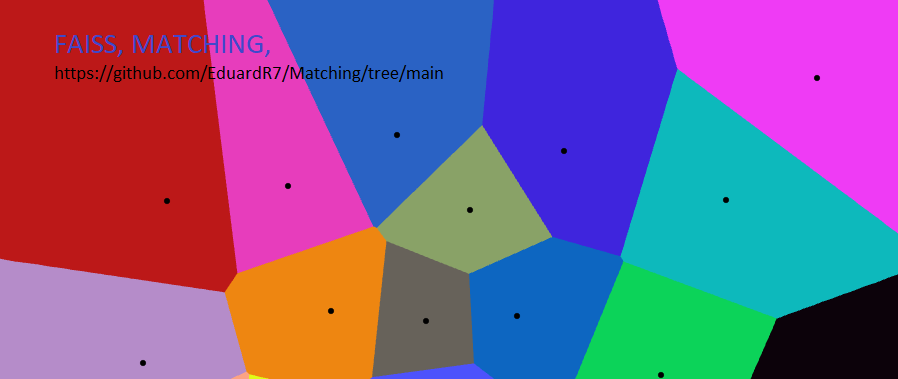

# Технологии использованные в проекте
### pandas, numpy, faiss, catboost

# Описание задачи
Заказчику необходимо внедрить систему поиска похожих элементов (мэтчинг).
Существует базовый набор, baseset, каждый элемент baseset это фактически отдельная категория.
Имеется обучающий и валидационный наборы.
На вход приходит вектор значений последнего скрытого слоя нейросети, эмбединг содержит 72 измерения.
На выходе нужно получить максиимальной близкий элемент из базового набора.

Имеющиеся данные:
- Baseset База эмбедингов более 3 млн значений
- Trainset выборка эмбедингов в 100 тыс. строк: новые товары, которым проставлено совпадение из базы
- Testset выборка в 100 тыс. строк
- Метрикой выбрана accuracy@5, acc@5 = 1, если из 5 результатов предоставлен релевантный

# Цель проекта

Найти алгоритм, который обеспечивает максимальную метрику за разумное время, т.е. без использования полного перебора по базе.

# План реализации:
1. Оптимизация решения, с использованием FAISS
2. Использование ранжирующего классификатора (CatBoost) с выдачей 5 наиболее подходящих кандидатов

In [1]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 46.7 MB/s eta 0:00:00


Управление работой программы, мета параметры

In [2]:
meta_p = {'init_size': 'mini', # full
          'make_mini': 'OK_make___', # Right answer 'save mini': 'OK_make_mini'
          'save_mini': 'OK_save___', # Right answer 'save mini': 'OK_save'
          'calc_regime': 'OK_full_calc___'
         } 

In [3]:
import pandas as pd
import numpy as np
from scipy.special import erf
from scipy.spatial import distance as dist

import faiss

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, CatBoostRegressor
from catboost import Pool, cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.utils.class_weight import compute_class_weight

import time
import json
from tqdm import tqdm
import joblib

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)
#### from tqdm.notebook import tqdm
from tqdm import tqdm


In [4]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler


In [5]:
pd.set_option('display.max_columns', 80)

### Константы количества соседей в output

In [6]:
in_ = {
    # Индекс
    'i_c': 100,     # Возможно, тут важно, именно 10, размеры кластеров 1250 для расчета индекса
    'i_g':50_000,    # размеры группы 50_000 для расчета индекса
    # Модель1
    'm1_c': 1250,
    'm1_k': 5,
    #'m1_acc: nan, сформируется на выходе
    # Нормализация
    'n_k': 5, 
    'n_c': 1250, #количество кластеров
    'n_g': 50_000,    # размеры группы 50_000 для расчета индекса
    'n_p': 10,
    #'n_acc: nan, сформируется на выходе
    # Корреляция
    'c_g': 500,# размер группы для вычисления корреляции
    'c_n': 6,# сколько выкидываем из плохой корреляции, пока не используем
    #DROP1
    'd1_c': 1250,
    'd1_p': 10,
    'd1_g': 50_000,
    'd1_k1': 5,
    #'d1_acc1: nan, сформируется на выходе
    'd1_k2': 100,
    #'d1_acc2: nan, сформируется на выходе
    'd1_k3': 1000,
    #'d1_acc3: nan, сформируется на выходе
    #DROP2
    'd2_c': 1250,
    'd2_k1': 5,
    #'d2_acc1: nan, сформируется на выходе
    'd2_k2': 100,
    #'d2_acc2: nan, сформируется на выходе
    'd2_k3': 1000,
    #'d2_acc3: nan, сформируется на выходе
    #DROP3
    'd3_c': 1250,
    'd3_k1': 5,
    #'d3_acc1: nan, сформируется на выходе
    'd3_k2': 100,
    #'d3_acc2: nan, сформируется на выходе
    #ERRF
    'e_c': 1250,
    'e_k1': 5,
    #'e_acc1: nan, сформируется на выходе
    'e_k2': 100,
    #'e_acc2: nan, сформируется на выходе
    'e_k3': 1000,
    #'e_acc3: nan, сформируется на выходе
    'e_k4': 2500,
    #'e_acc4: nan, сформируется на выходе
}

if meta_p['init_size'] == 'mini':
    in_ = {
        # Индекс
        'i_c': 100,     # Возможно, тут важно, именно 10, размеры кластеров 1250 для расчета индекса
        'i_g':5000,    # размеры группы 50_000 для расчета индекса
        # Модель1
        'm1_c': 100,
        'm1_k': 5,
        #'m1_acc: nan, сформируется на выходе
        # Нормализация
        'n_k': 5, 
        'n_c': 100, #количество кластеров
        'n_g':10000,    # размеры группы 50_000 для расчета индекса
        'n_p': 10,
        #'n_acc: nan, сформируется на выходе
        # Корреляция
        'c_g': 500,# размер группы для вычисления корреляции
        'c_n': 6,# сколько выкидываем из плохой корреляции, пока не используем
        #DROP1
        'd1_c': 100,
        'd1_p': 10,
        'd1_g': 10_000,
        'd1_k1': 5,
        #'d1_acc1: nan, сформируется на выходе
        'd1_k2': 100,
        #'d1_acc2: nan, сформируется на выходе
        'd1_k3': 1000,
        #'d1_acc3: nan, сформируется на выходе
        #DROP2
        'd2_c': 100,
        'd2_p': 10,
        'd2_g': 10_000,
        'd2_k1': 5,
        #'d2_acc1: nan, сформируется на выходе
        'd2_k2': 100,
        #'d2_acc2: nan, сформируется на выходе
        'd2_k3': 1000,
        #'d2_acc3: nan, сформируется на выходе
        #DROP3
        'd3_c': 100,
        'd3_p': 10,
        'd3_g': 10_000,
        'd3_k1': 5,
        #'d3_acc1: nan, сформируется на выходе
        'd3_k2': 100,
        #'d3_acc2: nan, сформируется на выходе
        #ERRF

        'e_c': 100,
        'e_p': 10, 
        'e_g': 10_000,
        'e_k1': 5,
        #'e_acc1: nan, сформируется на выходе
        'e_k2': 100,
        #'e_acc2: nan, сформируется на выходе
        'e_k3': 1000,
        #'e_acc3: nan, сформируется на выходе
        'e_k4': 2000,
        #'e_acc4: nan, сформируется на выходе
    }
out_ = in_

In [7]:
f_number = 72
k = 5
k100 = 100
k250 = 250
k1000 = 1000
k2500 = 2500


## Константы количества кластеров

In [8]:
n_cells = 1250
c10 = 10
c50 = 50
c100 = 100
c250 = 250
c500 = 500

## Константы группировки

In [9]:
g100_000 = 100_000
g50_000 = 50_000
g10_000 = 10_000
g5_000 = 5_000
g500 = 500
g100 = 100
g10 = 10

## Functions

def acc_pd1(targets, idx, base_index):
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        set__ = set(base_index.keys())
        #print(len(set__))
        for r in el:
            if r not in set__:
                print('Something wrong',target)
                print(el)
        list__ = [base_index[r] for r in el]
        acc += int(target in list__)
    return 100 * acc / len(idx)

In [10]:
# Определение функций

def acc_k():
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    return 100 * acc / len(idx)

def acc_pd(targets, idx, base_index):
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    return 100 * acc / len(idx)

def get_dist(vec_1, vec_2):
    #'''
    #принимает на вход 2 вектора, возвращает список расстояний
    #'''
    distances = [
        dist.braycurtis(vec_1,vec_2),
        dist.canberra(vec_1,vec_2),
        dist.chebyshev(vec_1,vec_2),
        dist.cityblock(vec_1,vec_2), #Manhattan
        dist.correlation(vec_1,vec_2),
        dist.cosine(vec_1,vec_2),
        dist.euclidean(vec_1,vec_2),
        dist.minkowski(vec_1,vec_2,3),
        dist.minkowski(vec_1,vec_2,5)
    ]
    return distances

"""def vecs_idx(k=100,
             rs=StandardScaler(),
             drop_cols1=drop_cols1,
             df_base=df_base,
             df_train=df_train,
             n_clasters=in_['d1_c'],
             n_in_group=in_['d1_g']
            ):
    
    #rs = StandardScaler()
    df_base3 = rs.fit_transform(df_base.drop(columns=drop_cols1))
    df_train3 = rs.transform(df_train.drop(columns=drop_cols1))
    
    dims = df_base3.shape[1]
    #print([column],dims)
    quantizer3 = faiss.IndexFlatL2(dims)
    idx_l3 = faiss.IndexIVFFlat(quantizer3, dims, n_clasters) ## 100 кластеров
    idx_l3.nprobe = in_['d1_p'] # 10 проб
    
    idx_l3.train(np.ascontiguousarray(df_base3[:n_in_group, :]).astype('float32')) # 10_000 подряд
    idx_l3.add(np.ascontiguousarray(df_base3).astype('float32'))
    
    #vecs, idx = idx_l3.search(np.ascontiguousarray(df_train3).astype('float32'), k_)
    
    return idx_l3.search(np.ascontiguousarray(df_train3).astype('float32'), k)"""

def make_features(candidates, query):
    #'''
    #принимает на вход:
    #candidates - список индексов из base
    #query - запрос (изначальный вектор)
    #
    #возвращает: список расстояний между изначальным запросом
    #и каждым кандидатом
    #########################################
    # Будет замена на numpy
    #'''
    distances = []
    vec_1 = query
    for candidate in candidates:
        vec_2 = base_array[candidate][mask]
        distances.append(get_dist(vec_1,vec_2))
    return np.array(distances)

def get5(arr):
    #'''сортирует массив, полученный 
    #из predict_proba и возвращает
    # 5 наиболее близких к 1
    #'''
    return arr[:,0].argsort()[:5]


def concat_(candidates, query, base):    
    #'''
    #принимает на вход:
    #candidates - список индексов из base
    #query - запрос (изначальный вектор)
    #base - массив для построения индекса
    #
    #возвращает: попарно сконкатенированные векторы
    #            из запроса с векторами кандидатов
    #'''
    concatenated_vec = []
    vec_1 = query
    for candidate in candidates:
        vec_2 = base[candidate]
        concatenated_vec.append(np.concatenate([vec_1,vec_2]))
    return np.array(concatenated_vec)

def concat_w_dist(candidates, query, base):
    #'''
    # принимает на вход:
    # candidates - список индексов из base
    # query - запрос (изначальный вектор)
    # base - массив для построения индекса
    #
    # возвращает: попарно сконкатенированные векторы
    #            из запроса с векторами кандидатов 
    #            и дистанциями между этими векторами
    # Думаю здесь бы еще докинуть - вектор с меньшими размерностями, центр кластера _____
    #########################################
    # Будет замена на numpy
    #'''
    concatenated_vecs = []
    vec_1 = query
    for candidate in candidates:
        vec_2 = base[candidate]
        concatenated_vec = np.concatenate([vec_1,vec_2])
        distances = get_dist(vec_1, vec_2)
        concatenated_vec = np.concatenate([concatenated_vec,distances])
        concatenated_vecs.append(concatenated_vec)
    return np.array(concatenated_vecs)

df_base = pd.DataFrame()
df_train = pd.DataFrame()
df_test = pd.DataFrame()
test_target = pd.Series()

def make_set(train_length = 100,
             test_length = 100,
             base_length = 2918,
             df_base=df_base,
             df_train = df_train,
             df_test=df_test,
             test_target=test_target):
    
    str2int = lambda s: int(s.split('-')[0])
    
    df_train['index2'] = df_train.index.map(str2int) # для сохранения порядка сортировки, строки сортируются плохо
    df_train1 = df_train.sample(train_length).sort_values('index2')
    df_train = df_train.drop('index2', axis=1)
    df_train1 = df_train1.drop('index2', axis=1)
    
    df_test['index2'] =df_test.index.map(str2int)
    df_test1 = df_test.sample(test_length).sort_values('index2')
    df_test = df_test.drop('index2', axis=1)
    df_test1 = df_test1.drop('index2', axis=1)
    test_target1 = test_target[test_target.index.isin(df_test1.index)]
    
    df_base['index2'] = df_base.index.map(str2int)
    ##base_set = set(df_train['Target']).union(set(test_target['Expected'])) 
    base_set = set(df_train1['Target']).union(set(test_target1)) 
    df_base1 = df_base[df_base.index.isin(base_set)]
    df_temp = df_base[~df_base.index.isin(base_set)].sample(base_length-train_length-test_length)
    
    df_base1 = pd.concat([df_base1, df_temp]).sort_values('index2')
    df_base = df_base.drop('index2', axis=1)
    df_base1 = df_base1.drop('index2', axis=1)
    
    del df_temp
    
    #print(df_base1.shape)
    #print(df_train1.shape)
    #print(df_test1.shape)
    #print(test_target1.shape)
    
    return df_base1, df_train1, df_test1, test_target1

## Файл вывода

In [11]:
#submit = pd.DataFrame(range(5),columns=[])

# Load data

Уменьшаем объем памяти заменой float64 на float32

In [12]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

In [13]:
len(dict_base)

72

In [14]:
%%time
if meta_p['init_size'] == 'mini':
    df_base = pd.read_table("/kaggle/input/yp-match-mini/base_mini.csv", index_col=0, sep=',', dtype=dict_base)
else:
    df_base = pd.read_table("/kaggle/input/yp-matching/base.csv", index_col=0, sep=',', dtype=dict_base)
#df_base = df_base.head(500000)
df_base.head(3)

CPU times: user 9.34 s, sys: 690 ms, total: 10 s
Wall time: 14.5 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6-base,-132.349777,12.640369,-80.635895,-137.117950,89.345490,-94.853523,-462.933990,91.356033,126.557274,147.394897,-181.880569,58.696495,-102.881424,2.471200,84.739349,-17.143242,-21.006647,-59.817440,-150.996872,-79.834366,-136.834549,1507.231323,-45.633701,69.276871,69.863846,813.770081,-119.121384,9.931257,-77.459129,169.675323,0.382531,-193.034500,86.016701,-735.671387,3.285198,77.668694,-0.339467,-145.260483,-126.975021,-63.341637,-27.670044,2.442018,-141.594315,71.634789,-36.717823,57.680214,-91.298866,-117.489799,85.105148,-75.370880,-59.305614,-72.856247,63.820702,-248.026443,93.809944,56.622749,-123.449677,-11.332070,-56.313950,-298.441803,-86.127258,-129.899429,-55.650047,29.008305,-138.246124,156.300507,67.054199,-25.324776,85.734146,138.853516,-1070.516235,-2.041809
10-base,-98.898865,5.633918,-88.647285,-158.901001,87.810623,-76.610001,6.748629,-27.250978,126.672394,120.379913,-69.643311,32.361221,-75.553856,-19.171476,148.400864,-8.120407,-12.796442,-58.470451,-151.602615,-78.167038,-98.558983,1507.231323,-30.044306,65.107346,17.424585,813.770081,-52.768528,21.956285,-43.711967,144.816559,0.264757,-81.064247,82.520706,-537.183716,63.333008,78.018784,-26.554935,-136.884781,-119.835587,-61.248772,-2.231911,13.014480,-168.285034,140.914185,-18.251749,52.974163,-128.652985,-178.777634,86.286728,-106.065575,50.332970,-4.723828,55.014900,-156.981491,92.193092,81.170013,-133.377411,-82.370537,-126.686676,-127.214333,-66.410454,-135.847015,-81.505669,19.662066,-125.733261,18.915529,67.413277,48.166084,146.343658,117.060417,-1152.302124,-73.153015
12-base,-68.859093,-0.939237,-47.824863,-153.827682,89.371063,-83.141739,-529.278503,39.693317,118.244225,140.705521,-106.737183,-60.128113,-62.713448,-0.832265,187.592346,-12.485569,10.218163,-79.680832,-117.098877,-80.099777,-89.162697,1507.231323,4.163849,19.670410,35.199646,813.770081,-48.678822,23.768454,-119.076950,142.818481,-24.367599,-147.595383,61.878609,-156.249893,67.057892,58.734184,-34.786446,-140.631653,-122.438278,-52.909172,-15.099993,2.717432,-164.555161,97.492470,-40.675041,97.359741,-85.340134,-95.672455,63.186111,50.399780,85.273285,-105.022049,76.801010,-78.387726,77.942543,50.955841,-130.448868,-72.047569,-175.977173,-663.639771,-134.824646,-127.555878,-58.820076,76.393723,-180.409897,85.385712,67.940689,-20.363411,162.172638,120.761597,-1092.484985,-64.907616


In [15]:
##type(df_base.loc['0-base','0'])
df_base[['0','1']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 583600 entries, 6-base to 4744763-base
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       583600 non-null  float32
 1   1       583600 non-null  float32
dtypes: float32(2)
memory usage: 8.9+ MB


In [16]:
## del
len(list(df_base.index.unique()))

583600

In [17]:
%%time
if meta_p['init_size'] == 'mini':
    df_train = pd.read_csv("/kaggle/input/yp-match-mini/train_mini.csv", index_col=0, dtype=dict_train)
else:
    df_train = pd.read_csv("/kaggle/input/yp-matching/train.csv", index_col=0, dtype=dict_train)
#df_base = df_base.head(500000)
#df_base.head(3)
#df_train.head()
df_train.shape

CPU times: user 335 ms, sys: 29 ms, total: 364 ms
Wall time: 511 ms


(20000, 73)

In [18]:
%%time
if meta_p['init_size'] == 'mini':
    df_test = pd.read_csv("/kaggle/input/yp-match-mini/validation_mini.csv", index_col=0, dtype=dict_base)
else:
    df_test = pd.read_csv("/kaggle/input/yp-matching/validation.csv", index_col=0, dtype=dict_base)
#df_base = df_base.head(500000)

df_test.shape

CPU times: user 323 ms, sys: 24.6 ms, total: 348 ms
Wall time: 490 ms


(20000, 72)

In [19]:
%%time
if meta_p['init_size'] == 'mini':
    test_target = pd.read_csv("/kaggle/input/yp-match-mini/validation_answer_mini.csv", index_col=0, dtype=dict_base).squeeze()
else:
    test_target = pd.read_csv("/kaggle/input/yp-matching/validation_answer.csv", index_col=0, dtype=dict_base).squeeze()
test_target.shape

CPU times: user 25.6 ms, sys: 4.08 ms, total: 29.7 ms
Wall time: 40.9 ms


(20000,)

## Создаем мини наборы, для более быстрой обработки.
## Все наборы корректно уменьшаем в 5 раз

Размер до которого уменьшаем df_base

In [20]:
if meta_p['make_mini'] == 'OK_make_20%':
    df_base1, df_train1, df_test1, test_target1 = make_set(train_length = 2000, test_length = 2000, base_length = 2918*20, df_base=df_base, df_train = df_train, df_test=df_test, test_target=test_target)
    df_test1.to_csv('validation_20%.csv')
    df_train1.to_csv('train_20%.csv')
    df_base1.to_csv('base_20%.csv')
    test_target1.to_csv('validation_answer_20%.csv')
    df_base = df_base1
    df_train = df_train1
    df_test = df_test1
    test_target = test_target1

if meta_p['make_mini'] == 'OK_make_01%':
    df_base1, df_train1, df_test1, test_target1 = make_set(train_length = 100, test_length = 100, base_length = 2918, df_base=df_base, df_train = df_train, df_test=df_test, test_target=test_target)
    df_test1.to_csv('validation_01%.csv')
    df_train1.to_csv('train_01%.csv')
    df_base1.to_csv('base_01%.csv')
    test_target1.to_csv('validation_answer_01%.csv')
    df_base = df_base1
    df_train = df_train1
    df_test = df_test1
    test_target = test_target1


In [21]:
print(df_base.shape)
print(df_train.shape)
print(df_test.shape)
print(test_target.shape)

(583600, 72)
(20000, 73)
(20000, 72)
(20000,)


### Create index

In [22]:
#del 
dims = df_base.shape[1]
dims

72

In [23]:
%%time
dims = df_base.shape[1]
#n_cells = 1250
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, in_['i_c'])
idx_l2.train(np.ascontiguousarray(df_base.values[:in_['i_g'], :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

CPU times: user 1.67 s, sys: 302 ms, total: 1.97 s
Wall time: 621 ms


In [24]:
in_['i_c']

100

## Словарь для конвертации индексов

### Base
Это словарь для перевода №строки base в ее название

In [25]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

base_index_inverted = {v:k for k,v in base_index.items()}
#del df_base

In [26]:
list(zip(list(base_index.keys())[:5],list(base_index.values())[:5]))

[(0, '6-base'), (1, '10-base'), (2, '12-base'), (3, '13-base'), (4, '14-base')]

In [27]:
list(zip(list(base_index_inverted.keys())[:5],list(base_index_inverted.values())[:5]))

[('6-base', 0), ('10-base', 1), ('12-base', 2), ('13-base', 3), ('14-base', 4)]

### Train
Это словарь для перевода № строки Train в ее название в формате Base

In [28]:
train_id_index = {k: v for k, v in enumerate(df_train.index.to_list())}
train_id_index_inverted = {v:k for k,v in train_id_index.items()}
#del df_base
print(list(zip(list(train_id_index.keys())[:5],list(train_id_index.values())[:5])))
print(list(zip(list(train_id_index_inverted.keys())[:5],list(train_id_index_inverted.values())[:5])))

[(0, '1-query'), (1, '14-query'), (2, '17-query'), (3, '21-query'), (4, '24-query')]
[('1-query', 0), ('14-query', 1), ('17-query', 2), ('21-query', 3), ('24-query', 4)]


In [29]:
train_index = {k: v for k, v in enumerate(df_train['Target'].to_list())}
train_index_inverted = {v:k for k,v in train_index.items()}
#del df_base
print(list(zip(list(train_index.keys())[:5],list(train_index.values())[:5])))
print(list(zip(list(train_index_inverted.keys())[:5],list(train_index_inverted.values())[:5])))

[(0, '366656-base'), (1, '88328-base'), (2, '1841709-base'), (3, '9331-base'), (4, '915740-base')]
[('366656-base', 0), ('88328-base', 1), ('1841709-base', 2), ('9331-base', 3), ('915740-base', 4)]


### Test

In [30]:
test_target.head()
#test_target['Expected'].head()

Id
100004-query      75484-base
100005-query    1905037-base
100007-query    1533713-base
100010-query     641788-base
100013-query      11032-base
Name: Expected, dtype: object

In [31]:
test_id_index = {k: v for k, v in enumerate(test_target.index.to_list())}
test_id_index_inverted = {v:k for k,v in test_id_index.items()}
#del df_base
print(list(zip(list(test_id_index.keys())[:5],list(test_id_index.values())[:5])))
print(list(zip(list(test_id_index_inverted.keys())[:5],list(test_id_index_inverted.values())[:5])))

[(0, '100004-query'), (1, '100005-query'), (2, '100007-query'), (3, '100010-query'), (4, '100013-query')]
[('100004-query', 0), ('100005-query', 1), ('100007-query', 2), ('100010-query', 3), ('100013-query', 4)]


In [32]:
test_index = {k: v for k, v in enumerate(test_target.tolist())}
test_index_inverted = {v:k for k,v in test_index.items()}
#del df_base
print(list(zip(list(test_index.keys())[:5],list(test_index.values())[:5])))
print(list(zip(list(test_index_inverted.keys())[:5],list(test_index_inverted.values())[:5])))

[(0, '75484-base'), (1, '1905037-base'), (2, '1533713-base'), (3, '641788-base'), (4, '11032-base')]
[('75484-base', 0), ('1905037-base', 1), ('1533713-base', 2), ('641788-base', 3), ('11032-base', 4)]


# First model

In [33]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [34]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), in_['m1_k'])

acc_k()

CPU times: user 6 s, sys: 14.4 ms, total: 6.01 s
Wall time: 1.63 s


7.57

In [35]:
pd.DataFrame.from_dict(out_, orient='index').to_csv('sub.csv')

# EDA

In [36]:
df_samples = df_train[:in_[ 'e_g']] # in_[ 'e_g': 5000]

CPU times: user 5.5 s, sys: 50.4 ms, total: 5.55 s
Wall time: 5.57 s


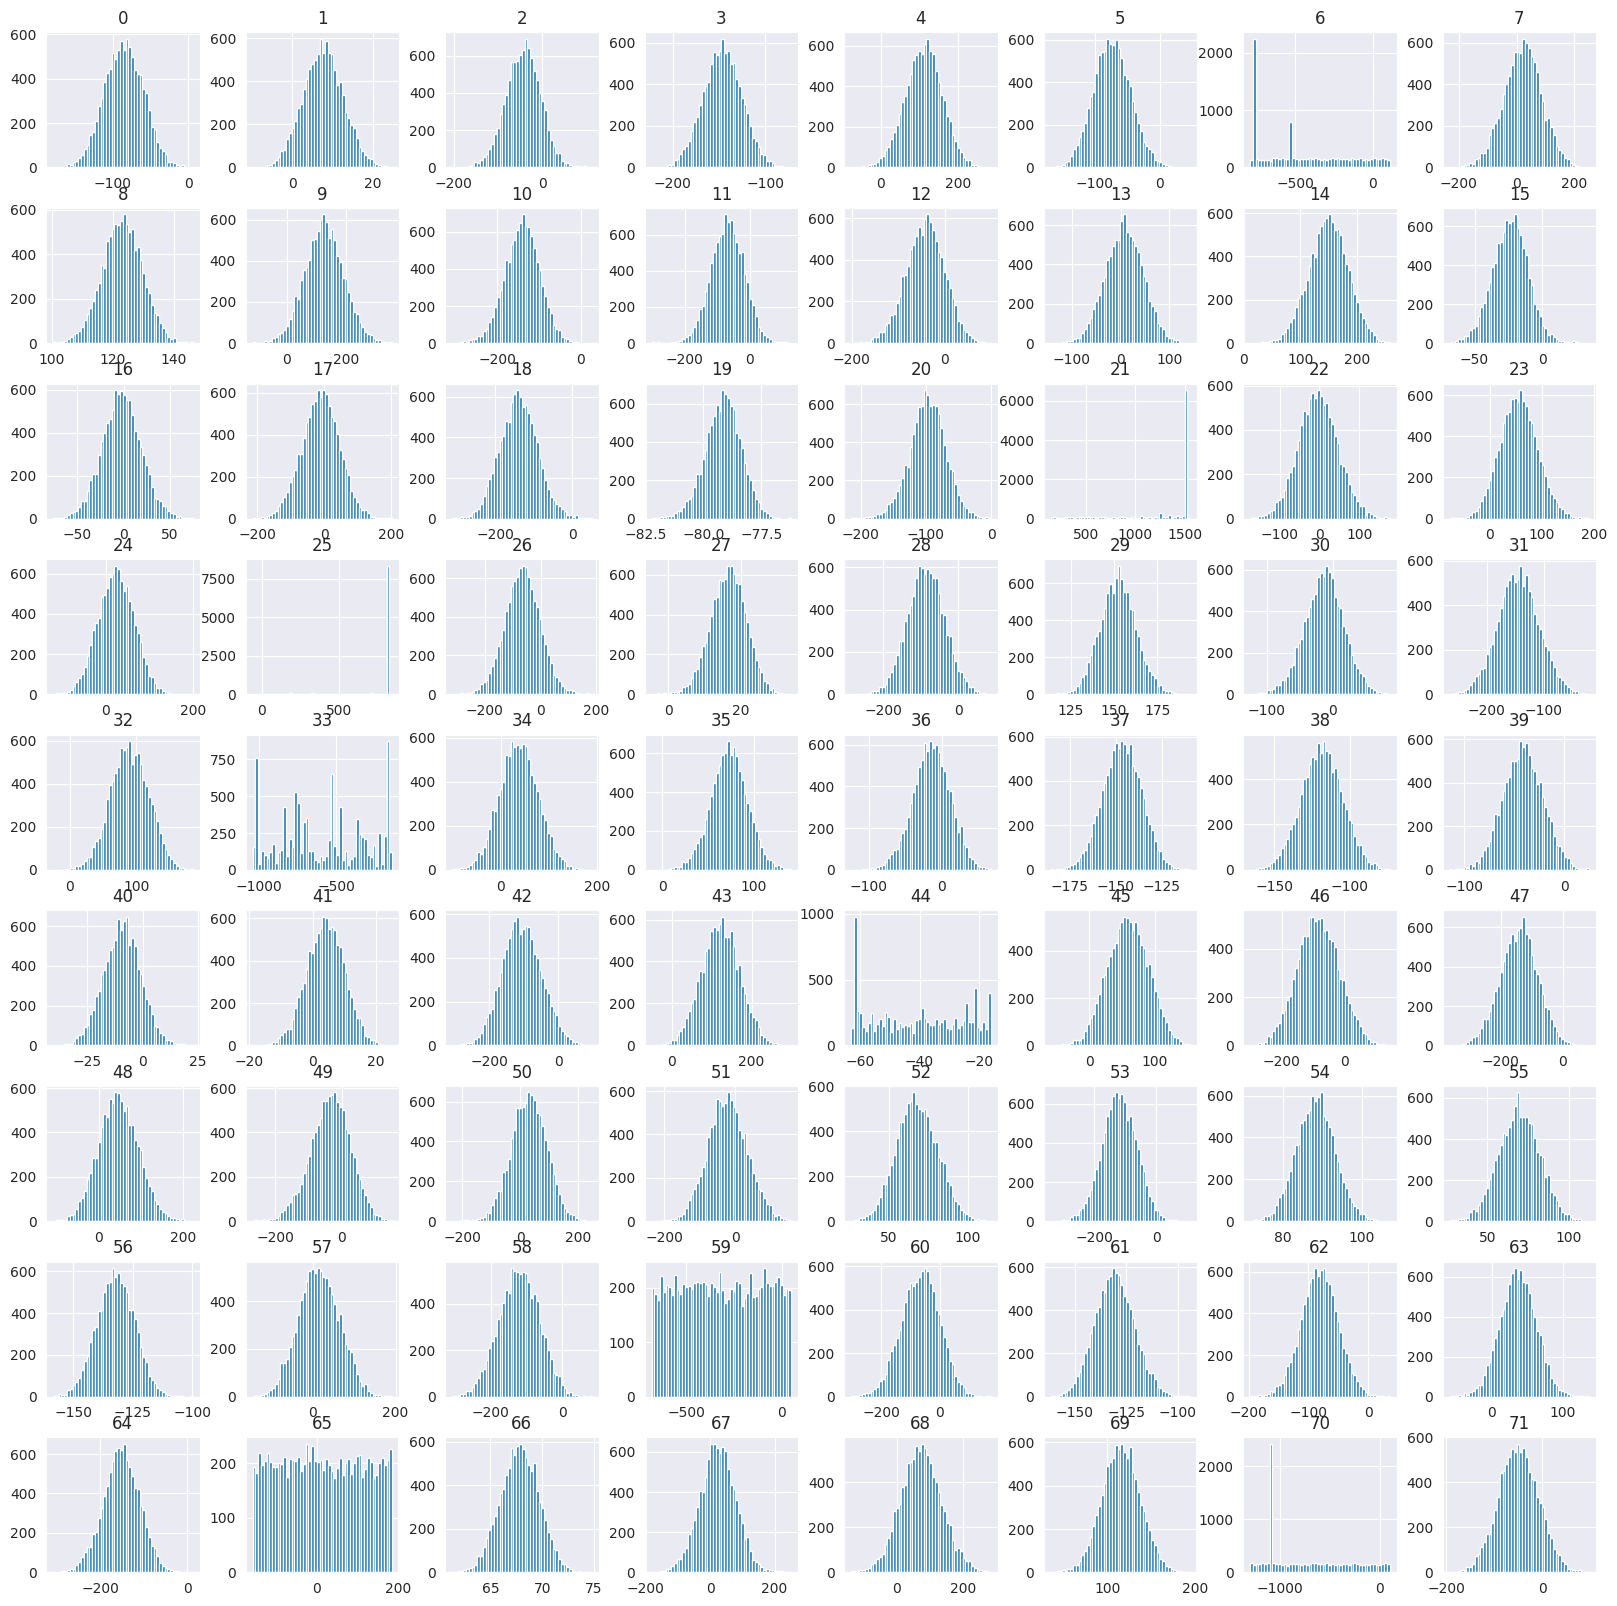

In [37]:
%%time
df_samples.hist(figsize=[20, 20], bins=50);

Нехарактерные данные - 6, 21, 25, 33, 44, 59, 65, 70.
Надо по очереди их удалить из набора, увидеть как меняется метрика

# Нормализация данных

In [38]:
### del
idx_l2.nprobe

1

In [39]:
scalers = [RobustScaler(), StandardScaler(), MaxAbsScaler()]

In [40]:
%%time
##in_['n_p'] = 10
acc_norm_dict = {}
for scaler in [StandardScaler()]:
    df_base2 = scaler.fit_transform(df_base)
    df_train2 = scaler.transform(df_train)
    dims = df_base2.shape[1]
    quantizer2 = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, in_['n_c'])
    idx_l2.nprobe = in_['n_p']
    
    idx_l2.train(np.ascontiguousarray(df_base2[:in_['n_g'], :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))

    vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), in_['n_k'])
    print(scaler, acc_k())
    
out_['n_acc'] = acc_k()
#'n_acc: nan, сформируется на выходеacc = 0


StandardScaler() 70.595
CPU times: user 1min 4s, sys: 362 ms, total: 1min 4s
Wall time: 16.9 s


### Получается StandartScaler самый лучший
### Масштабирование существенно улучшает скор

In [41]:
# Периодически сохраняемся
pd.DataFrame.from_dict(out_, orient='index').to_csv('sub.csv')

# Поочередное удаление нехарактерных признаков

### Спорный подход с помощью корреляции

In [42]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833
14-query,-107.745506,8.262278,1.303707,-122.309601,124.886330,-113.067261,-759.626038,-50.134232,125.861702,107.053070,-90.002632,-140.398544,-77.879105,2.836091,132.823059,-51.801544,17.839813,-31.496952,-139.009308,-78.378166,-38.505711,1425.660645,72.867699,22.059883,10.318062,813.770081,-95.787971,13.434817,-149.971649,150.458206,-15.886305,-99.975983,108.026703,-607.946899,45.545483,56.166698,33.295334,-146.401291,-131.078247,-37.816662,-17.858135,10.784974,-125.222389,190.422852,-61.144287,52.384800,-41.958611,-97.028252,-39.184620,5.011368,-21.041828,-36.728626,76.339981,-152.378479,78.257156,57.870007,-125.719223,100.640305,-136.433014,2.871017,-147.695343,-142.723816,-77.386719,19.192116,-169.014618,129.329819,69.071838,-21.853165,91.174057,86.220680,-951.979248,-119.347946
17-query,-64.541153,6.379174,22.827354,-140.190079,118.121468,-45.949471,-167.825531,76.232231,116.561600,36.988052,-158.484085,-24.544483,28.408382,14.443172,165.117661,-10.285959,-0.427095,-136.568237,-138.260513,-78.485367,-77.214012,1248.126221,-58.981449,2.498821,27.260263,813.770081,-109.076599,16.930973,-180.744385,162.503510,22.885384,-155.350052,126.658783,-529.295044,-2.739601,112.386536,7.201660,-151.959442,-121.878639,-32.530106,-4.576903,18.125595,-36.182640,127.292580,-22.416134,80.314026,-36.021545,-93.207275,14.003819,-114.341370,0.339888,66.548111,55.256084,-203.570602,85.190163,76.355522,-125.917084,25.617558,-269.394714,-536.457275,-74.469810,-131.410461,-99.924271,68.939438,-232.424271,-151.365799,66.982071,21.464298,31.847046,125.621956,-1179.731079,-48.768707
21-query,-41.343288,12.988533,-52.500469,-177.084045,117.425499,-64.219170,-759.626038,119.854683,116.598770,28.824615,-170.582230,-12.652462,-130.508972,-14.959316,136.723358,-11.430122,-24.218765,-133.244751,-153.187164,-79.458450,-146.607178,1507.231323,-49.837742,42.037971,28.480858,813.770081,-77.841217,17.331118,-54.596519,164.445312,-12.468549,-104.941620,114.944939,-782.400574,75.419052,92.663483,42.130188,-146.589478,-100.663948,-81.191994,-11.556769,2.137828,-143.834167,137.751801,-31.666388,32.576809,-96.822418,-171.633011,42.394432,-37.890240,-3.922165,-21.375587,73.619629,-126.059509,87.283264,67.766876,-132.100906,-4.545560,-138.801880,-555.050659,-51.942348,-129.312698,-48.169018,33.574203,-140.074295,-74.130066,70.309479,22.298388,53.082397,113.545525,-653.411011,8.083492
24-query,-133.162888,-2.366189,-24.341312,-163.206894,136.807861,-64.591225,-759.626038,0.566725,121.067207,166.230515,-121.215073,47.510681,-49.381374,21.131439,139.708191,-39.037285,-12.009003,4.315985,-163.969086,-79.927345,-102.858505,790.665405,-52.458607,5.540699,-2.005230,-33.176945,-42.398232,11.203355,-64.874832,156.825607,36.022892,-91.570923,93.245766,-544.598816,58.623032,83.177177,27.879902,-158.545486,-106.063339,0.531914,-0.512160,4.863410,-173.031097,114.842873,-17.441359,45.396679,-228.339569,-106.698746,50.675858,70.76109

In [43]:
corr1 = df_train.iloc[:in_['c_g']]
corr1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833
14-query,-107.745506,8.262278,1.303707,-122.309601,124.886330,-113.067261,-759.626038,-50.134232,125.861702,107.053070,-90.002632,-140.398544,-77.879105,2.836091,132.823059,-51.801544,17.839813,-31.496952,-139.009308,-78.378166,-38.505711,1425.660645,72.867699,22.059883,10.318062,813.770081,-95.787971,13.434817,-149.971649,150.458206,-15.886305,-99.975983,108.026703,-607.946899,45.545483,56.166698,33.295334,-146.401291,-131.078247,-37.816662,-17.858135,10.784974,-125.222389,190.422852,-61.144287,52.384800,-41.958611,-97.028252,-39.184620,5.011368,-21.041828,-36.728626,76.339981,-152.378479,78.257156,57.870007,-125.719223,100.640305,-136.433014,2.871017,-147.695343,-142.723816,-77.386719,19.192116,-169.014618,129.329819,69.071838,-21.853165,91.174057,86.220680,-951.979248,-119.347946
17-query,-64.541153,6.379174,22.827354,-140.190079,118.121468,-45.949471,-167.825531,76.232231,116.561600,36.988052,-158.484085,-24.544483,28.408382,14.443172,165.117661,-10.285959,-0.427095,-136.568237,-138.260513,-78.485367,-77.214012,1248.126221,-58.981449,2.498821,27.260263,813.770081,-109.076599,16.930973,-180.744385,162.503510,22.885384,-155.350052,126.658783,-529.295044,-2.739601,112.386536,7.201660,-151.959442,-121.878639,-32.530106,-4.576903,18.125595,-36.182640,127.292580,-22.416134,80.314026,-36.021545,-93.207275,14.003819,-114.341370,0.339888,66.548111,55.256084,-203.570602,85.190163,76.355522,-125.917084,25.617558,-269.394714,-536.457275,-74.469810,-131.410461,-99.924271,68.939438,-232.424271,-151.365799,66.982071,21.464298,31.847046,125.621956,-1179.731079,-48.768707
21-query,-41.343288,12.988533,-52.500469,-177.084045,117.425499,-64.219170,-759.626038,119.854683,116.598770,28.824615,-170.582230,-12.652462,-130.508972,-14.959316,136.723358,-11.430122,-24.218765,-133.244751,-153.187164,-79.458450,-146.607178,1507.231323,-49.837742,42.037971,28.480858,813.770081,-77.841217,17.331118,-54.596519,164.445312,-12.468549,-104.941620,114.944939,-782.400574,75.419052,92.663483,42.130188,-146.589478,-100.663948,-81.191994,-11.556769,2.137828,-143.834167,137.751801,-31.666388,32.576809,-96.822418,-171.633011,42.394432,-37.890240,-3.922165,-21.375587,73.619629,-126.059509,87.283264,67.766876,-132.100906,-4.545560,-138.801880,-555.050659,-51.942348,-129.312698,-48.169018,33.574203,-140.074295,-74.130066,70.309479,22.298388,53.082397,113.545525,-653.411011,8.083492
24-query,-133.162888,-2.366189,-24.341312,-163.206894,136.807861,-64.591225,-759.626038,0.566725,121.067207,166.230515,-121.215073,47.510681,-49.381374,21.131439,139.708191,-39.037285,-12.009003,4.315985,-163.969086,-79.927345,-102.858505,790.665405,-52.458607,5.540699,-2.005230,-33.176945,-42.398232,11.203355,-64.874832,156.825607,36.022892,-91.570923,93.245766,-544.598816,58.623032,83.177177,27.879902,-158.545486,-106.063339,0.531914,-0.512160,4.863410,-173.031097,114.842873,-17.441359,45.396679,-228.339569,-106.698746,50.675858,70.76109

In [44]:
corr2 = df_base.loc[targets[:in_['c_g']].values.tolist()]
corr2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
366656-base,-88.614189,4.574929,-22.700304,-144.943237,80.877815,-92.111588,-530.528137,-18.696142,114.099472,163.910553,-119.127937,-52.455498,54.283619,-15.019310,180.153305,-6.344114,10.021841,80.891541,-131.300476,-78.144768,-105.745026,1507.231323,14.772253,146.901917,-23.800430,813.770081,-167.192657,14.617152,-47.320404,159.014313,2.719553,-239.746536,116.866859,-156.249893,35.982323,73.236694,-41.084225,-148.842529,-135.714417,-68.386841,0.439651,1.887420,-199.569244,95.647545,-18.751057,118.715591,27.385803,-96.774872,42.764679,-40.232586,73.783852,-18.575270,65.894836,-45.601562,91.997475,70.962364,-131.135056,-88.374298,-117.930389,-196.239960,9.245659,-132.142883,-77.159775,12.424929,-162.745178,85.860939,70.269699,-15.091993,48.642250,101.123978,-1074.464844,-71.665268
88328-base,-107.745506,8.262278,1.303707,-122.309601,124.886330,-113.067261,-759.626038,-50.134232,125.861702,107.053070,-90.002632,-140.398544,-77.879105,2.836091,132.823059,-51.801544,17.839813,-31.496952,-139.009308,-78.378166,-38.505711,1425.660645,72.867699,22.059883,10.318062,813.770081,-95.787971,13.434817,-149.971649,150.458206,-15.886305,-99.975983,108.026703,-744.244202,45.545483,56.166698,33.295334,-146.401291,-131.078247,-37.816662,-17.858135,10.784974,-125.222389,190.422852,-61.144287,52.384800,-41.958611,-97.028252,-39.184620,5.011368,-21.041828,-36.728626,76.339981,-152.378479,78.257156,57.870007,-125.719223,100.640305,-136.433014,-85.160324,-147.695343,-142.723816,-77.386719,19.192116,-169.014618,129.329819,69.071838,-21.853165,91.174057,86.220680,-951.979248,-119.347946
1841709-base,-61.244366,3.030471,21.326363,-140.077209,161.945786,-66.221024,-446.878448,85.711243,116.038719,79.002670,-160.325912,-9.953018,-42.980850,-7.553738,176.555588,-32.904835,-32.049500,-71.170441,-211.268341,-78.506577,-71.504631,1507.231323,-35.898392,51.206303,66.345154,813.770081,-99.642509,13.836980,-79.946899,157.909790,-3.019239,-132.789398,57.841778,-366.139435,25.689720,68.895073,-3.685530,-146.424438,-137.018173,-32.596416,-9.137990,4.945405,-49.430595,120.466698,-22.416134,-11.198902,-60.556839,-102.667404,31.462353,-105.332352,114.723160,28.439871,70.101524,-113.520126,85.985847,100.208992,-127.976341,-34.359695,-118.859230,-561.496460,-115.529457,-138.902496,-92.336502,79.694260,-183.411697,-13.470067,68.104385,54.019745,76.641602,143.550140,-1074.464844,8.208858
9331-base,-41.343288,12.988533,-52.500469,-177.084045,117.425499,-64.219170,-759.626038,119.854683,116.598770,28.824615,-170.582230,-12.652462,-130.508972,-14.959316,136.723358,-11.430122,-24.218765,-133.244751,-153.187164,-79.458450,-146.607178,1507.231323,-49.837742,42.037971,28.480858,813.770081,-77.841217,17.331118,-54.596519,164.445312,-12.468549,-104.941620,114.944939,-452.133789,75.419052,92.663483,42.130188,-146.589478,-100.663948,-81.191994,-11.556769,2.137828,-143.834167,137.751801,-31.666388,32.576809,-96.822418,-171.633011,42.394432,-37.890240,-3.922165,-21.375587,73.619629,-126.059509,87.283264,67.766876,-132.100906,-4.545560,-138.801880,-118.956871,-51.942348,-129.312698,-48.169018,33.574203,-140.074295,-74.130066,70.309479,22.298388,53.082397,113.545525,-653.411011,8.083492
915740-base,-73.770508,2.179944,-86.125229,-172.867661,147.953247,-70.498352,-621.258301,21.439175,125.775665,209.273132,-172.287216,12.069893,-25.803543,1.421923,161.545273,-41.369186,1.495278,-73.548111,-188.756088,-79.761612,-59.590210,1415.658813,0.446689,-0.414478,28.000338,813.770081,15.994972,10.118938,-52.645760,155.486206,29.667454,-133.775009,78.519592,-560.414490,18.667501,54.965294,31.368572,-160.413300,-120.051819,-0.359310,-5.694774,5.621110,-192.124939,95.600296,-56.213417,68.612610,-193.841919,-150.998001,103

In [45]:
%%time
print(corr1.shape)
print(corr2.shape)

(500, 72)
(500, 72)
CPU times: user 319 µs, sys: 8 µs, total: 327 µs
Wall time: 335 µs


In [46]:
%%time
t = pd.DataFrame.from_dict({col_id: np.corrcoef(corr1.iloc[:, col_id], corr2.iloc[:, col_id])[0, 1] for col_id in range(0, 72) },orient="index").sort_values(0, ascending=False)#[-10:]

### t = pd.DataFrame.from_dict({col_id: np.corrcoef(corr1.iloc[:, col_id], corr2.iloc[:, col_id])[0, 1] for col_id in range(0, 72) },orient="index")
### t.sort_values(0, ascending=False).groupby(col_id).mean()



CPU times: user 25.7 ms, sys: 0 ns, total: 25.7 ms
Wall time: 25.5 ms


In [47]:
t[-30:]

,0
10,0.813309
15,0.811977
39,0.811543
17,0.810577
32,0.810127
54,0.808650
52,0.806476
2,0.806176
61,0.804398
13,0.803207


In [48]:
in_['i_g']

5000

In [49]:
print(in_['n_c'], in_['d1_c'])
print(in_['n_g'], in_['d1_g'])
in_['d1_k1']

100 100
10000 10000


5

In [50]:
out_['n_acc']
in_['d1_p']

10

### Сейчас последовательно убираем каждый из нехарактерных признаков,
### смотрим как это сказывается на acc@5,распечатываем результаты

In [51]:
###del idx_l3, df_base3, df_train3
###%%time
drop_cols1 = [str(el) for el in [6, 21, 25, 33, 44, 59, 65, 70]]

acc_delcol_dict = {}
acc_delcol_dict['n_acc'] = out_['n_acc']
#drop_cols1 = [str(el) for el in [33, 6]]

for column in tqdm(drop_cols1, total = len(drop_cols1)):

    #del idx_l3, df_base3, df_train3, rs, vecs, idx
    rs = StandardScaler()
    df_base3 = rs.fit_transform(df_base.drop(columns=[column]))
    df_train3 = rs.transform(df_train.drop(columns=[column]))
    
    dims = df_base3.shape[1]
    #print([column],dims)
    quantizer3 = faiss.IndexFlatL2(dims)
    idx_l3 = faiss.IndexIVFFlat(quantizer3, dims, in_['d1_c'])
    idx_l3.nprobe = in_['d1_p']
    
    idx_l3.train(np.ascontiguousarray(df_base3[:in_['d1_g'], :]).astype('float32'))
    idx_l3.add(np.ascontiguousarray(df_base3).astype('float32'))
    
    vecs, idx = idx_l3.search(np.ascontiguousarray(df_train3).astype('float32'), 5)
    #print()
    ###acc = 0
    ###for target, el in zip(targets.values.tolist(), idx.tolist()):
    ###    acc += int(target in [base_index[r] for r in el])
    
    ###acc = 100 * acc / len(idx)
    acc_delcol_dict[column] = acc_k()
#acc_delcol_dict['n_acc'] = out_['n_acc']
print(acc_delcol_dict)
display(pd.DataFrame.from_dict(acc_delcol_dict,orient="index").sort_values(0, ascending=False))
pd.DataFrame.from_dict(out_, orient='index').to_csv('sub.csv')

100%|██████████| 8/8 [02:24<00:00, 18.11s/it]

{'n_acc': 70.595, '6': 70.095, '21': 71.17, '25': 72.065, '33': 72.28, '44': 70.88, '59': 71.13, '65': 70.99, '70': 70.195}


,0
33,72.280
25,72.065
21,71.170
59,71.130
65,70.990
44,70.880
n_acc,70.595
70,70.195
6,70.095


### На этом наборе получается накидывает - изьятие - 33, 25, 21, 59, 65, 44 - остальные два 70 и 6 убирать не надо, скор падает

In [52]:
meta_p['calc_regime']

'OK_full_calc___'

### Здесь заложена возможность провести Feature Importance, удалив поочередно каждый из 72 признаков.
### Наибольшее влияние на скор, по прежнему оказывает - изьятие 33, 25, 21, 59, 65, 44

In [53]:
###del idx_l3, df_base3, df_train3
###%%time
if meta_p['calc_regime'] == 'OK_full_calc':
    drop_cols1 = [str(el) for el in df_base.columns]
    acc_delcol_dict = {}
    acc_delcol_dict['n_acc'] = out_['n_acc']
    #drop_cols1 = [str(el) for el in [33, 6]]

    for column in tqdm(drop_cols1, desc='Processing', total = len(drop_cols1)):

        #del idx_l3, df_base3, df_train3, rs, vecs, idx
        rs = StandardScaler()
        df_base3 = rs.fit_transform(df_base.drop(columns=[column]))
        df_train3 = rs.transform(df_train.drop(columns=[column]))
    
        dims = df_base3.shape[1]
        #print([column],dims)
        quantizer3 = faiss.IndexFlatL2(dims)
        idx_l3 = faiss.IndexIVFFlat(quantizer3, dims, in_['d1_c'])
        idx_l3.nprobe = in_['d1_p']
    
        idx_l3.train(np.ascontiguousarray(df_base3[:in_['d1_g'], :]).astype('float32'))
        idx_l3.add(np.ascontiguousarray(df_base3).astype('float32'))
    
        vecs, idx = idx_l3.search(np.ascontiguousarray(df_train3).astype('float32'), 5)
        #print()
        ###acc = 0
        ###for target, el in zip(targets.values.tolist(), idx.tolist()):
        ###    acc += int(target in [base_index[r] for r in el])
    
        ###acc = 100 * acc / len(idx)
        acc_delcol_dict[column] = acc_k()
    print(acc_delcol_dict)
    pd.DataFrame.from_dict(acc_delcol_dict,orient="index").sort_values(0, ascending=False)


### Здесь заложена возможность изменения величины каждой фичи, после Standart Scaler.
### Это также было сделано. Но результат не впечатлил
### Общий вывод - подбором можно поднять скор не более 0.1% на лучшие признаки.

In [54]:
if meta_p['calc_regime'] == 'OK_full_calc':
    acc_delcol_dict1 = {}
    acc_delcol_dict1['n_acc'] = out_['n_acc']
    #drop_cols1 = [str(el) for el in [33, 6]]

    for x in tqdm(np.arange(0.95, 1.05, 0.005), desc='Processing'):
        #del df_base3, df_train3, idx_l3
        rs = StandardScaler()
        df_base3 = rs.fit_transform(df_base.drop(columns=drop_cols1))
        df_train3 = rs.transform(df_train.drop(columns=drop_cols1))
        
        dims = df_base3.shape[1]
        df_base3[:,6] = x * df_base3[:,6]
        df_train3[:,6] = x * df_train3[:,6]
        #print([column],dims)
        quantizer3 = faiss.IndexFlatL2(dims)
        idx_l3 = faiss.IndexIVFFlat(quantizer3, dims, in_['d1_c'])
        idx_l3.nprobe = in_['d1_p']
        
        idx_l3.train(np.ascontiguousarray(df_base3[:in_['d1_g'], :]).astype('float32'))
        idx_l3.add(np.ascontiguousarray(df_base3).astype('float32'))
    
        vecs, idx = idx_l3.search(np.ascontiguousarray(df_train3).astype('float32'), 5)
        #print()
        ###acc = 0
        ###for target, el in zip(targets.values.tolist(), idx.tolist()):
        ##    acc += int(target in [base_index[r] for r in el])
        
        ###acc = 100 * acc / len(idx)
        acc_delcol_dict1[str(x)] = acc_k()
        

    pd.DataFrame.from_dict(acc_delcol_dict1,orient="index").sort_values(0, ascending=False)[:10]


### Оценим влияние количества кандидатов в выборке, от acc@5 до acc@1000
### Формально, влияние очень сильное - +10% к скору (до 0.8575)
### Вопрос - можно ли этот виртуальный скор превратить в реальный, улучшив ранжированием

In [55]:
drop_cols1 = [str(el) for el in [33, 25, 21, 59, 65, 44]]

acc_delcol_dict2 = {}
#acc_delcol_dict2['n_acc'] = out_['n_acc']
##acc_delcol_dict2['d1_acc'] = out_['d1_acc']

#drop_cols1 = [str(el) for el in [33, 6]]

for k_ in tqdm([5, 50, 100, 150, 200, 250, 500, 1000], desc='Processing'):
    #del df_base3, df_train3, idx_l3
    rs = StandardScaler()
    df_base3 = rs.fit_transform(df_base.drop(columns=drop_cols1))
    df_train3 = rs.transform(df_train.drop(columns=drop_cols1))
    
    dims = df_base3.shape[1]
    #print([column],dims)
    quantizer3 = faiss.IndexFlatL2(dims)
    idx_l3 = faiss.IndexIVFFlat(quantizer3, dims, in_['d1_c'])
    idx_l3.nprobe = in_['d1_p']
    
    idx_l3.train(np.ascontiguousarray(df_base3[:in_['d1_g'], :]).astype('float32'))
    idx_l3.add(np.ascontiguousarray(df_base3).astype('float32'))
    
    vecs, idx = idx_l3.search(np.ascontiguousarray(df_train3).astype('float32'), k_)
    #print()
    ###acc = 0
    ###for target, el in zip(targets.values.tolist(), idx.tolist()):
    ##    acc += int(target in [base_index[r] for r in el])
    
    ###acc = 100 * acc / len(idx)
    acc_delcol_dict2[str(k_)] = acc_k()
    out_['d1_acc' + str(k_)] = acc_k()
    print(acc_pd(targets, idx, base_index))
    #print(acc_pd1(targets, idx, base_index))

pd.DataFrame.from_dict(out_, orient='index').to_csv('sub.csv')
pd.DataFrame.from_dict(acc_delcol_dict2,orient="index").sort_values(0, ascending=False)[:10]


Processing:  12%|█▎        | 1/8 [00:16<01:56, 16.59s/it]

75.555


Processing:  25%|██▌       | 2/8 [00:34<01:43, 17.18s/it]

81.375


Processing:  38%|███▊      | 3/8 [00:53<01:31, 18.24s/it]

82.595


Processing:  50%|█████     | 4/8 [01:14<01:16, 19.24s/it]

83.18


Processing:  62%|██████▎   | 5/8 [01:37<01:01, 20.55s/it]

83.51


Processing:  75%|███████▌  | 6/8 [02:01<00:43, 21.83s/it]

83.91


Processing:  88%|████████▊ | 7/8 [02:33<00:25, 25.22s/it]

84.87


Processing: 100%|██████████| 8/8 [03:21<00:00, 25.25s/it]

85.715


,0
1000,85.715
500,84.870
250,83.910
200,83.510
150,83.180
100,82.595
50,81.375
5,75.555


### Результат даже на acc@100 = 82.6%
### Насколько этот скор реален?

# Использование функции ошибок, Erf function

In [56]:
drop_cols1
in_['e_p']

10

In [57]:
#drop_cols1 = [str(el) for el in [33, 25, 21, 65, 59]]

acc_delcol_dict3 = {}
acc_delcol_dict3['n_acc'] = out_['n_acc']
acc_delcol_dict3['d1_acc5'] = out_['d1_acc5']
acc_delcol_dict3['d1_acc1000'] = out_['d1_acc1000']

#drop_cols1 = [str(el) for el in [33, 6]]

for k_ in tqdm([5, 50, 100, 150, 200, 250, 500, 1000], desc='Processing'):
    #del df_base3, df_train3, idx_l3
    rs = StandardScaler()
    df_base3 = erf(rs.fit_transform(df_base.drop(columns=drop_cols1)))
    df_train3 = erf(rs.transform(df_train.drop(columns=drop_cols1)))
    
    dims = df_base3.shape[1]
    quantizer3 = faiss.IndexFlatL2(dims)
    idx_l3 = faiss.IndexIVFFlat(quantizer3, dims, in_['e_c'])
    idx_l3.nprobe = in_['e_p']
    
    idx_l3.train(np.ascontiguousarray(df_base3[:in_['e_g'], :]).astype('float32'))
    idx_l3.add(np.ascontiguousarray(df_base3).astype('float32'))
    
    vecs, idx = idx_l3.search(np.ascontiguousarray(df_train3).astype('float32'), k_)
    #print()
    ###acc = 0
    ###for target, el in zip(targets.values.tolist(), idx.tolist()):
    ##    acc += int(target in [base_index[r] for r in el])
    
    ###acc = 100 * acc / len(idx)
    acc_delcol_dict3[str(k_)] = acc_k()
    out_['e_acc' + str(k_)] = acc_k()
    print(acc_pd(targets, idx, base_index))

pd.DataFrame.from_dict(out_, orient='index').to_csv('sub.csv')
pd.DataFrame.from_dict(acc_delcol_dict3,orient="index").sort_values(0, ascending=False)[:10]


Processing:  12%|█▎        | 1/8 [00:15<01:48, 15.49s/it]

74.94


Processing:  25%|██▌       | 2/8 [00:32<01:37, 16.29s/it]

80.895


Processing:  38%|███▊      | 3/8 [00:50<01:26, 17.25s/it]

82.32


Processing:  50%|█████     | 4/8 [01:11<01:13, 18.46s/it]

82.855


Processing:  62%|██████▎   | 5/8 [01:32<00:58, 19.53s/it]

83.205


Processing:  75%|███████▌  | 6/8 [01:56<00:41, 20.92s/it]

83.505


Processing:  88%|████████▊ | 7/8 [02:27<00:24, 24.38s/it]

84.41


Processing: 100%|██████████| 8/8 [03:15<00:00, 24.39s/it]

85.375


,0
d1_acc1000,85.715
1000,85.375
500,84.410
250,83.505
200,83.205
150,82.855
100,82.320
50,80.895
d1_acc5,75.555
5,74.940


### По факту ERF никак не помогла, ее результаты немного хуже
### Максимум для 5-и кандидатов acc@5 = 74.9%
### Виртуальный скор для ERF acc@100 = 82.32

In [58]:
in_['d1_c']
in_['d1_p']
in_['d1_g']
df_test.head()
#del vecs, idx
print(targets.head())
test_target.head()


Id
1-query      366656-base
14-query      88328-base
17-query    1841709-base
21-query       9331-base
24-query     915740-base
Name: Target, dtype: object


Id
100004-query      75484-base
100005-query    1905037-base
100007-query    1533713-base
100010-query     641788-base
100013-query      11032-base
Name: Expected, dtype: object

# Убираем 6 размерностей


### Тут важный момент - мы дальше переходим на 
### df_base3: numpy
### df_train3: numpy
### df_test3: numpy
### После этого этапа, размерность=66
### Но при этом все индексы сохранились, мы просто убрали ненужные размерности

In [59]:
rs=StandardScaler()
df_base3 = rs.fit_transform(df_base.drop(columns=drop_cols1))
df_train3 = rs.transform(df_train.drop(columns=drop_cols1))
df_test3 = rs.transform(df_test.drop(columns=drop_cols1))
    

In [60]:
print(df_base3.shape)
print(df_train3.shape)
print(df_test3.shape)

(583600, 66)
(20000, 66)
(20000, 66)


In [61]:
print(in_['d1_c'])
print(in_['d1_g'])

100
10000


### Функция генерит новые индексы idx_l3 (после уменьшения размерностей, и standartscaker

In [62]:
%%time
#######_, idxs_50 = index.search(np.ascontiguousarray(train_array[:,mask]).astype('float32'), 50)
###  accuracy_n(targets_train, idxs_50)
def vecs_idx3(k=100,
             #rs=StandardScaler(), #Здесь не нужно!!!
             #drop_cols1=drop_cols1, #Здесь не нужно!!!
             df_base3=df_base3 ,
             df_train3=df_train3,
             n_clasters=in_['d1_c'],
             n_in_group=in_['d1_g']
            ):
    
    #rs = StandardScaler()
    #df_base3 = rs.fit_transform(df_base.drop(columns=drop_cols1))
    #df_train3 = rs.transform(df_train.drop(columns=drop_cols1))
    
    dims = df_base3.shape[1]
    #print([column],dims)
    quantizer3 = faiss.IndexFlatL2(dims)
    idx_l3 = faiss.IndexIVFFlat(quantizer3, dims, n_clasters) ## 100 кластеров
    idx_l3.nprobe = in_['d1_p'] # 10 проб
    
    idx_l3.train(np.ascontiguousarray(df_base3[:n_in_group, :]).astype('float32')) # 10_000 подряд
    idx_l3.add(np.ascontiguousarray(df_base3).astype('float32'))
    
    #vecs, idx = idx_l3.search(np.ascontiguousarray(df_train3).astype('float32'), k_)
    
    return idx_l3.search(np.ascontiguousarray(df_train3).astype('float32'), k)


CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.9 µs


Подготавливаем данные для ранжирования

In [63]:
vecs_tr100, idx_tr100 = vecs_idx3()
vecs_te100, idx_te100 = vecs_idx3(df_train3=df_test3)


In [64]:
len(vecs_tr100[0])

100

In [65]:
print(acc_pd(targets, idx_tr100, base_index))
print(acc_pd(test_target, idx_te100, base_index))

82.595
82.785


In [66]:
print(df_base.shape)
print(df_train.shape)
print(vecs.shape)
print(idx_tr100.shape)

(583600, 72)
(20000, 72)
(20000, 1000)
(20000, 100)


In [67]:
print(vecs_tr100[:1])
print(idx_tr100[:1])
idx_tr100[0].shape

[[11.522851 21.178349 29.760118 30.317005 41.09848  43.998604 47.491646
  48.178436 48.31134  48.98123  50.456154 52.053104 52.07701  52.314587
  52.36022  52.40371  52.481205 52.536087 52.574306 52.592514 52.93379
  53.31884  53.385944 53.533936 53.540657 53.545162 53.992355 54.17307
  54.308807 54.50206  54.560577 54.795235 54.876873 54.912395 54.956795
  54.99534  55.144363 55.24642  55.421146 55.4256   55.45922  55.64456
  55.65826  55.83205  56.034092 56.062534 56.094017 56.195606 56.195988
  56.546066 56.67907  56.690273 56.718124 56.898827 57.14032  57.382023
  57.382072 57.412815 57.57252  57.68389  57.800575 57.806923 57.897724
  57.99578  58.020374 58.06838  58.145847 58.146523 58.196724 58.20951
  58.27533  58.29     58.30152  58.343987 58.400146 58.464832 58.51746
  58.637295 58.849213 58.87253  58.93634  58.957024 58.98904  59.013653
  59.065712 59.137966 59.16348  59.24793  59.33203  59.33938  59.34
  59.345074 59.361946 59.372902 59.37515  59.42369  59.492203 59.4959
  5

(100,)

In [68]:
print(len(vecs_tr100[0]))
vecs_tr100.shape
idx_tr100.shape

100


(20000, 100)

### Подготовка к ранжированию
### Функция make_ftr_trg3 генерит
#### target3 - состоит из Nстрок*100, т.е. 10млн. строк (1/0) для набора 100тыс. строк,
#### features3 - фичи для target3
#### features3_index, features3_base_indextarget3 - вида (0, '6-base'), (1, '10-base')

In [69]:
def make_ftr_trg3(idx_tr100, df_train3, df_base3, base_index):
    features3_index = []
    features3_base_index = []
    features3 = []
    target3 = []
    #for i, candidates in tqdm(enumerate(idx_tr100[:100]), total=idx_tr100.shape[0]):
    for i, candidates in tqdm(enumerate(idx_tr100), total=idx_tr100.shape[0]):
        vec1 = df_train3[i]
        features3.append(concat_w_dist(candidates, vec1, df_base3))
        features3_index.append(list(candidates)) 
        for candidate in candidates:
            features3_base_index.append(base_index[candidate])
        #vec_2 = df_base3[candidate]
            if targets[i] == base_index[candidate]: 
                target3.append(1)
            else:
                target3.append(0)
        
    features3 = np.vstack(features3)
    target3 = np.array(target3)
    return target3, features3, features3_index, features3_base_index
#print('sum(target3)', sum(target3))

In [70]:
target3, features3, features3_index, features3_base_index = make_ftr_trg3(idx_tr100, df_train3, df_base3, base_index)

100%|██████████| 20000/20000 [12:24<00:00, 26.86it/s]


In [71]:
print(target3.shape)
print(features3.shape)
print(len(features3_index))
print(len(features3_base_index))

(2000000,)
(2000000, 141)
20000
2000000


#### Виртуаальный скор - acc@100 = 82.5%

In [72]:
print(sum(target3)/len(target3))

0.0082595


In [73]:
import csv
np.save('features_100_drp6.npy', features3)
np.save('target_100_drp6.npy', target3)
with open('features3_index.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(features3_index)

with open('features3_base_index.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(features3_base_index)


# CatBoost

#### Посмотри CatBoost в лайт версии

In [74]:
x_train, x_test, y_train, y_test = train_test_split(features3,
                                                    target3,
                                                    test_size=0.2, 
                                                    random_state=42)
model3 = CatBoostClassifier(
    thread_count=-1,
    #learning_rate=0.4,
    ############################### Поставить 200
    #iterations=20,
    depth=4,
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_state=42,
    early_stopping_rounds=40
)

params = {"loss_function": "RMSE",
          #'learning_rate': 0.4,
          'verbose': 1000,
          #'iterations': 200,
          'depth': 4,
          "verbose": False}

model3.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=1000,
    use_best_model=True,
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.196032
0:	test: 0.9178432	best: 0.9178432 (0)	total: 758ms	remaining: 12m 37s
999:	test: 0.9802324	best: 0.9802746 (982)	total: 10m 10s	remaining: 0us

bestTest = 0.9802746039
bestIteration = 982

Shrink model to first 983 iterations.


In [75]:
vec1_list = ['v1_'+x for x in df_train.drop(columns=drop_cols1).columns]
cand_list = ['cn_'+x for x in df_train.drop(columns=drop_cols1).columns]
dist_list = ['brayc', 'canbr', 'cheby', 'cityb', 'corr', 'cos', 'eucl', 'mink3', 'mink5']
fin_list = vec1_list + cand_list + dist_list

In [76]:
len(fin_list)

141

In [77]:
##df_feature_importance = pd.DataFrame(data=model3.get_feature_importance(), columns=fin_list)
df_feature_importance = pd.DataFrame(data=list(model3.get_feature_importance()), index=fin_list)
df_feature_importance.sort_values(by=0, ascending=False).head(50)

,0
cityb,9.215953
cn_70,8.250715
v1_70,7.814174
eucl,5.338935
cos,4.792692
cn_6,3.178072
v1_6,3.055392
brayc,3.003347
canbr,2.556232
corr,2.080036


In [78]:
df_feature_importance.sort_values(by=0, ascending=False).tail(50)


,0
v1_34,0.297533
cn_34,0.294327
v1_51,0.293861
cn_16,0.290373
v1_46,0.287284
v1_69,0.286608
cn_28,0.286018
v1_13,0.285991
cn_54,0.283299
v1_22,0.281832


In [79]:
#df_feature_importance.sort_values(by=0, ascending=False).head(40)
df_feature_importance.sort_values(by=0, ascending=False).to_csv('df_feature_importance.csv')

Получается есть критические координаты, а есть не очень важные

# ROC/AUC

In [80]:
len(x_test)

400000

In [81]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(x_test, y_test)
curve = get_roc_curve(model3, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

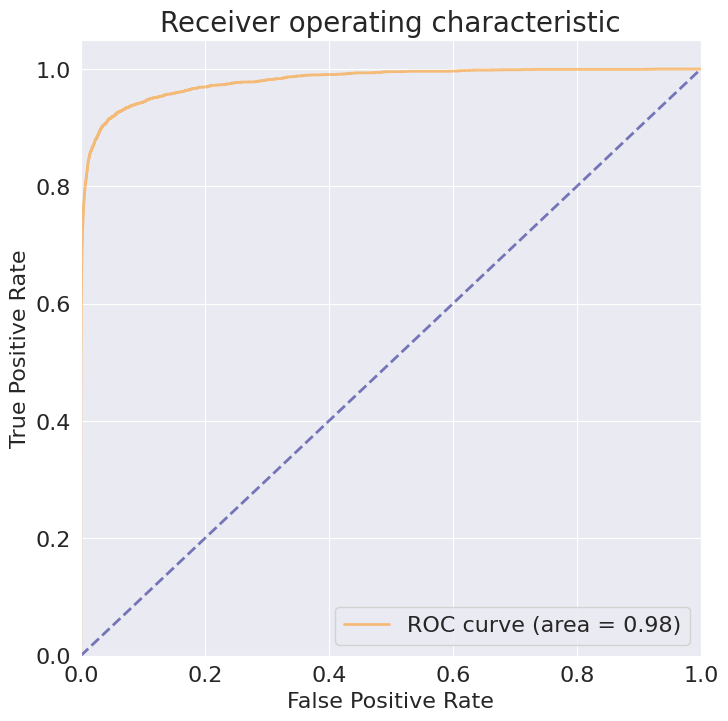

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

## Смотрится идеально, что в реальности?

In [83]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

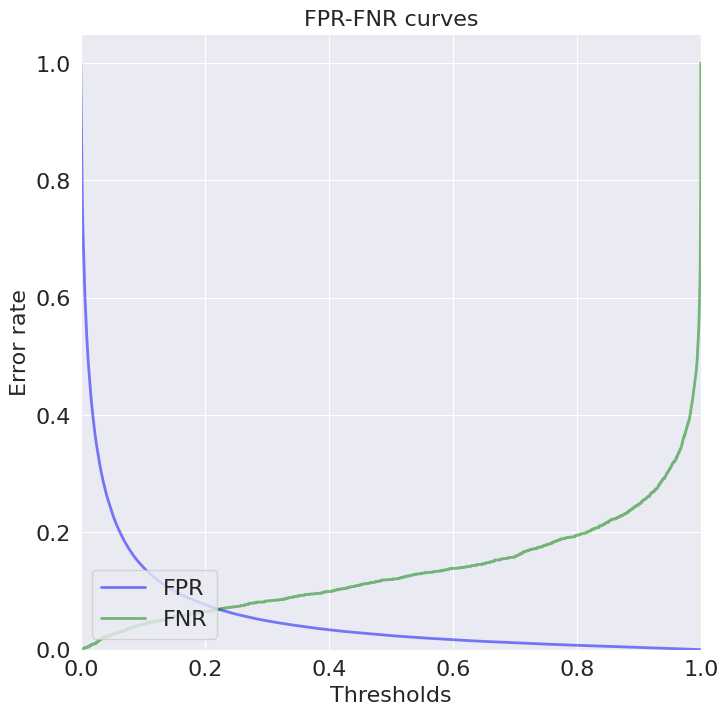

In [84]:
plt.figure(figsize=(8, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

In [85]:
from catboost.utils import select_threshold

print(select_threshold(model=model3, data=eval_pool, FNR=0.01))
print(select_threshold(model=model3, data=eval_pool, FPR=0.01))


0.022387479267699767
0.7416633194887385


# ранжирование

In [86]:
x_test[:20].shape

(20, 141)

In [87]:
preds = model3.predict(x_test[:50000])
print(roc_auc_score(y_train[:50000], model3.predict_proba(x_train[:50000])[:, 1]))
print(roc_auc_score(y_test[:50000], model3.predict_proba(x_test[:50000])[:, 1]))

0.9977083109036204
0.984685168379654


In [88]:

ind_temp = 15

def hand_made_check(ind_temp = 15,
                    df_train3=df_train3,
                    idx_tr100=idx_tr100,
                    df_base3=df_base3,
                    model3=model3,
                    targets=targets
                   ):
    query = df_train3[ind_temp]
    candidates = idx_tr100[ind_temp]
    ###df_base3.shape
    query_features = concat_w_dist(candidates, query, df_base3)
    top_5_candidates = candidates[get5(model3.predict_proba(query_features))]
    top_5_candidates_base = [base_index[i] for i in top_5_candidates]
    return targets[ind_temp], top_5_candidates_base


In [89]:
import random
acc5=0
number = 10000
for i in tqdm(range(number), total=number):
    ##target__,top_5_candidates_base = hand_made_check(ind_temp = random.randint(19990, 20000))
    target__,top_5_candidates_base = hand_made_check(ind_temp = i)
    #print(target__)
    #print(top_5_candidates_base)
    if target__ in top_5_candidates_base:
        acc5 += 1
print('Оценка acc@5 = ', acc5/number)

100%|██████████| 10000/10000 [07:39<00:00, 21.78it/s]

Оценка acc@5 =  0.8066


In [90]:
print('Мощное улучшение ', round((acc5 / number / 0.7555 - 1) * 100, 3), '%')

Мощное улучшение  6.764 %


## В итоге Catboost добавил меньше 1% 
